<h1>MatLab_Apply_Geo_FFT</h1>
<p>by Farnyuh Menq</p>
<p>NHERI@UTexas site Manager</p>
<p>2017/10/25</p>
<p>This notebook open a MatLab data file, apply geophone calibrtion factor and FFT.</p>

In [1]:
# import all the libraries needed
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import math
import os 

<h1>Step 1: Read channel map and calibration factors from an csv file. </h1>

In [2]:
#folder = r'C:\Users\fymenq.CAEE-MENQNHERI2\Desktop\201710_Sinkhole'
#folder = folder + '\\'
filename =  'Sinkhole_cal_ChMap.csv'
# Read csv file 
Cal_Fac = np.genfromtxt(filename, delimiter=',', skip_header=1)
print (Cal_Fac)

[[   1.    225.      0.      0.     12.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [   2.    235.      0.      0.     11.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [   3.    245.      0.      0.     10.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [   4.    255.      0.      0.      9.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [   5.    265.      0.      0.      8.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [   6.    275.      0.      0.      7.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [   7.    285.      0.      0.      6.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [   8.    295.      0.      0.      5.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [   9.    305.      0.      0.      4.      1.       nan    4.81    2.06
     0.68    1.      1.  ]
 [  10.    315.      0.      0.      3.      1.       nan    4.81    2.06
     0.68    1.  

<h1>Step 2: Open the MatLab data file</h1>

[('ChanNum', (52, 1), 'double'), ('Sensitivity', (52, 1), 'double'), ('SerialNo', (52,), 'char'), ('Unit', (52,), 'char'), ('ChanName', (52,), 'char'), ('ChanComment', (52,), 'char'), ('DP_Info', (312,), 'char'), ('X1', (131072, 2), 'double'), ('A1', (131072, 2), 'double'), ('X2', (131072, 2), 'double'), ('A2', (131072, 2), 'double'), ('X3', (131072, 2), 'double'), ('A3', (131072, 2), 'double'), ('X4', (131072, 2), 'double'), ('A4', (131072, 2), 'double'), ('X5', (131072, 2), 'double'), ('A5', (131072, 2), 'double'), ('X6', (131072, 2), 'double'), ('A6', (131072, 2), 'double'), ('X7', (131072, 2), 'double'), ('A7', (131072, 2), 'double'), ('X8', (131072, 2), 'double'), ('A8', (131072, 2), 'double'), ('X9', (131072, 2), 'double'), ('A9', (131072, 2), 'double'), ('X10', (131072, 2), 'double'), ('A10', (131072, 2), 'double'), ('X11', (131072, 2), 'double'), ('A11', (131072, 2), 'double'), ('X12', (131072, 2), 'double'), ('A12', (131072, 2), 'double'), ('X13', (131072, 2), 'double'), ('A13

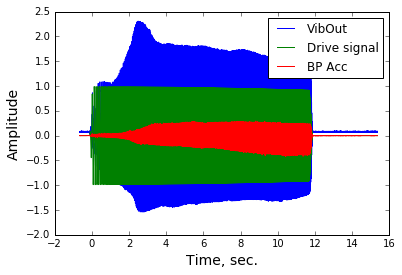

In [7]:
folder = r'C:\Users\fymenq.CAEE-MENQNHERI2\Desktop\Static\201710_Sinkhole\20171024\20171024 Sinkhole test.syn\MATLAB'
folder = folder + '\\'

MatLab_filename =  'DPsv00040.mat' # p-mode
# Read seg2 file using the obspy library
my_data = sio.loadmat(folder + MatLab_filename)
plt.plot (my_data['X50'][:,0], my_data['X50'][:,1],
         my_data['X49'][:,0], my_data['X49'][:,1],
         my_data['X51'][:,0], my_data['X51'][:,1])
print (sio.whosmat(folder + MatLab_filename))
# Create xlabel
plt.xlabel('Time, sec.', fontsize=14);
# Create ylabel
plt.ylabel('Amplitude', fontsize=14);
# set limits
#plt.ylim(0.0001, 1)
#plt.xlim(-0.015, 0.02)
plt.legend(['VibOut',
            'Drive signal', 
            'BP Acc'], loc=1)
plt.show()
#print (len(my_data['X50'][:,0]))

<h1>Step 3: read Sinkhole array Model data.</h1>

In [5]:
filename = "UOF_Header.vtk"
f= open(filename,'r')
model_data = f.read()
f.close()
#print (model_data)

<h1>Step 4: Define geophone calibration function.</h1>

In [6]:
def Apply_Geophone_Cal (dt, y, fn, G, D):
    '''
    Modified from Apply_Geophone_Cal.m MatLab Function
    # function [y1] = Apply_Geophone_Cal (dt, y, fn, G, D)
    # Apply geophone calibration spectrum on a time record 
    # By Farn-Yuh Menq and Clark R Wilson at NEES@UTexas 2012/2/14
    #
    # dt is delta time between data point 
    # y is the original time record
    # fn is the natural frequency of the geophone
    # G is the calibration factor (V/in.
    # D is damping ratio (not in #)
    # y1 is the time record with the applied calibration factors (including
    # amplitide and phase)
    #
    # This function transfer input time record (y) in to freq domain (Y), multiply
    # Y with the geophone calibration cruve (geo), and transfer it back to time
    # domain as y1.
    '''

    fs = 1.0/dt                    # Sampling frequency
    N = len(y)               # Length of signal

    # FFT
    Y = (np.fft.fft(y))*2.0/N
    # frequency array
    #f = [0:1/dt/N:1/2/dt]
    f = np.linspace (0, fs/2, N/2+1)

    # Generate a Geophone response (calibration) curve
    geo_amp = np.zeros(N)  # geophone calibration curve amplitude
    geo_phs = np.zeros(N)  # geophone calibration curve phase
    geo = np.zeros((N), np.complex64)      # geophone calibration curve complex number
    Y_cal = np.zeros((N), np.complex64)      # applied FFT(y) / geo
    geo_amp= G * f**2/((fn**2-f**2)**2+(2*D*fn*f)**2)**0.5
    
    for j in range (0, int(N/2+1)):
        #geo_amp[j]= G * f[j]**2/((fn**2-f[j]**2)**2+(2*D*fn*f[j])**2)**0.5
        if (fn**2-f[j]**2) == 0:
            geo_phs[j]= -np.pi/2.0
        else:
            geo_phs[j]= -math.atan(2*D*fn*f[j]/(fn**2-f[j]**2))
        if geo_phs[j] > 0:
            geo_phs[j] = geo_phs[j] - np.pi
        geo[j] = geo_amp[j] * np.cos(geo_phs[j]) + geo_amp[j] * np.sin(geo_phs[j])*1j
        if j > 0: 
           geo[-j]= np.conj(geo[j])
        # Devide FFT Original signal with calibration factor - Transfer function
        if geo[j] != 0:
            Y_cal[j] = Y[j]/geo[j]
            Y_cal[-j] = Y[-j]/geo[-j]
        else:
            Y_cal[j] = 0.0
            Y_cal[-j] = 0.0

   
    # set 0 to first n_0 data points - geophones do not work well at low
    # frequency range
    n_0 = int(fn*0.1*fs)
    if n_0 ==0: n_0= 3
    if n_0 > 10: n_0 = 10
    for j in range (-n_0, n_0+1):
        Y_cal[j] = 0
    Y_cal[int(N/2)] = 0  # Set the value at the Nyquist frequency to 0 to ensure
    #no imagary part. 

    # Inverse FFT
    Y_cal = Y_cal * N/2.0
    y1=np.fft.ifft(Y_cal)
    if y1.imag.max() < 1e-10:
        y1 = y1.real
    return y1


<h1>Step 5: Apply Geophone calibration factor to each time record.</h1>

In [7]:
conv_data = np.zeros((48, len(my_data['X1'][:,0])))
Ch_name = ['X1', 'X2','X3', 'X4','X5', 'X6','X7', 'X8','X9', 'X10',
           'X11', 'X12','X13', 'X14','X15', 'X16','X17', 'X18','X19', 'X20',
           'X21', 'X22','X23', 'X24','X25', 'X26','X27', 'X28','X29', 'X30',
           'X31', 'X32','X33', 'X34','X35', 'X36','X37', 'X38','X39', 'X40',
           'X41', 'X42','X43', 'X44','X45', 'X46','X47', 'X48',]
samping_rate = (my_data['X1'][-1,0] - my_data['X1'][0,0])/(len(my_data['X1'][:,0])-1)
for i in range(48):
    # update calibration factor to account the gain setting of the DAS
    # G * DAS gain
    Cal_Fac_G = Cal_Fac[i, 8] * Cal_Fac[i, 11]
    # apply geophone calibration and put the result in conv_data
    # note conv_data is in sequency of sensor location, my_data is in sequency of channels
    
    conv_data[i, :] = Apply_Geophone_Cal(samping_rate,
            my_data[Ch_name[int(Cal_Fac[i, 4]-1)]][:,1]  * Cal_Fac[i, 10], # Cal_Fac[i, 10] is the polirity use "-1" for reverse
            fn = Cal_Fac[i, 7], G = Cal_Fac_G, D = Cal_Fac[i, 9])
    

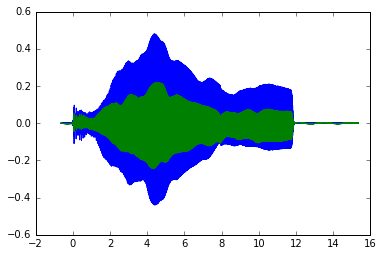

In [43]:
plt.plot (my_data['X1'][:,0], my_data['X12'][:,1],
          my_data['X1'][:,0], conv_data[0, :]
         )

In [91]:
print(my_data['X1'][102000,0])
print (1/samping_rate/10/15)

11.8111572266
54.6133333333


<h1>Step 6: FFT.</h1>

In [40]:
def Norm_fft(t, y):
    # Normalized FFT
    N = len (t)
    dt = (t[-1] - t[0])/(N-1)
    f = np.linspace(0.0, 1.0/(2.0*dt), N/2+1)
    yf = np.fft.fft(y)/N
    Y = yf[0:int(N/2+1)]
    return f, Y

In [41]:
fft_data = np.zeros((48, int(len(my_data['X1'][:,0])/2+1)), dtype=np.complex64)
for i in range(48):
    _f, fft_data[i,:] = Norm_fft(my_data['X1'][:,0], conv_data[i, :])

<function matplotlib.pyplot.show>

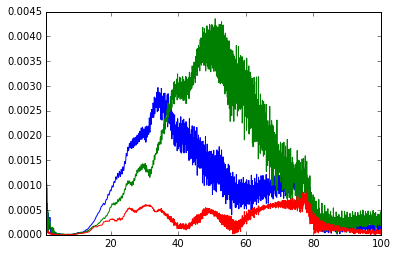

In [42]:
plt.plot (_f, np.absolute(fft_data[0, :]),
         _f, np.absolute(fft_data[1, :]),
         _f, np.absolute(fft_data[2, :]))
plt.xlim([1,100])
plt.show